# Isidro Intent Classification (BERT-Based Transfer Learning)

This notebook fine-tunes BERT to perform intent classification for Isidro, and compares that model performance to AutoML and BQML models.

Adapted from Prof. Dr. Johannes Maucher's [Intent Classification with BERT](https://hannibunny.github.io/mlbook/transformer/intent_classification_with_bert.html)

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been shown to be successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup

#### __Configuration__

The notebook depends on pre-configured authentication to Google Cloud Platform.  For example, you could use a Vertex AI Workbench notebook, with a sufficiently-credentialed service account.  Otherwise, Google Cloud authentication needs to be added.

In [1]:
# CHANGE THESE

# The project should already exist and have Vertex/GCS/BigQuery APIs enabled
# A "playground" project is recommended for isolation and easy teardown
GCP_PROJECT = "example"

# Name only - bucket will be created in the notebook
GCP_BUCKET = "isidro_intent_classification"

In [2]:
# OPTIONALLY, CHANGE THESE
DATA_FILE = "quality.csv"
GCP_REGION = "us-central1"
VERTEX_MODEL_NAME_PREFIX = "isidro_intents"
VERTEX_MODEL_ROUND = "r1"  # suffix for differentiating separate models (e.g., when running this notebook multiple times)
VERTEX_MODEL_DESCRIPTION = "Isidro intent classification model"
EXPERIMENT_NAME = "isidro-intents-compare-custom-automl-bqml"
BQ_DATASET = "isidro_intents"  # name only - dataset will be created in the notebook

In [3]:
# TUNE THESE ON LATER ITERATIONS
EPOCHS = 8  # custom tensorflow model epochs
LEARNING_RATE = 1e-5  # custom tensorflow model learning rate (Adam optimizer)
BATCH_SIZE = 32  # custom tensorflow model batch size
BERT_MODEL_NAME = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  # base model for transfer learning

#### __Dependencies__

In [4]:
!pip install -r service/requirements.txt

#### __Handle imports, utilites, and staging storage__

In [5]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from google.cloud import exceptions

binarizer = LabelBinarizer()

tf.get_logger().setLevel('ERROR')
rcParams['figure.figsize'] = 12, 8
warnings.filterwarnings("ignore")

#### __Create Cloud Storage bucket__

In [6]:
from google.cloud import storage

storage_client = storage.Client()

try:
    bucket = storage_client.bucket(GCP_BUCKET)
    bucket.storage_class = "STANDARD"
    new_bucket = storage_client.create_bucket(bucket, location=GCP_REGION)
except exceptions.Conflict:
    print("Bucket already exists - choose a new name if the bucket is not under your control")
    pass

## Custom model

#### __Data preparation__

In [7]:
df = pd.read_csv(DATA_FILE)

# Split off a testing dataset
train_df, test_df = train_test_split(df, test_size=0.16, random_state=42)

# Split the remaining data into training and validation datasets
train_df, valid_df = train_test_split(train_df, test_size=0.19, random_state=42)

train_df.shape, test_df.shape, valid_df.shape

((347, 2), (82, 2), (82, 2))

In [8]:
# Separate out features and labels (training)
train_copy = train_df.copy()
train_labels = train_copy.pop("intent")
train_labels = binarizer.fit_transform(train_labels.values)
train_features = train_copy.values
intent_count = train_labels.shape[1]

In [9]:
# Separate out features and labels (testing)
test_copy = test_df.copy()
test_labels = test_copy.pop("intent")
test_labels = binarizer.transform(test_labels.values)
test_features = test_copy.values

In [10]:
# Separate out features and labels (validation)
valid_copy = valid_df.copy()
valid_labels = valid_copy.pop("intent")
valid_labels = binarizer.transform(valid_labels.values)
valid_features = valid_copy.values

#### __Load model from TensorFlow Hub__

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

In [11]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[BERT_MODEL_NAME]
tfhub_handle_preprocess = map_model_to_preprocess[BERT_MODEL_NAME]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


#### __The preprocessing model__

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2023-01-17 22:50:26.002258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-01-17 22:50:26.002306: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-17 22:50:26.002335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-8-20230117-000657): /proc/driver/nvidia/version does not exist
2023-01-17 22:50:26.002591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

Let's try the preprocessing model on some text and see the output:

In [13]:
train_features[0]

array(['Can you tell me how to change the scale of one of your microservices?'],
      dtype=object)

In [14]:
text_test = train_features[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2064 2017 2425 2033 2129 2000 2689 1996 4094 1997 2028]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As can be seen, there are 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

#### __Using the BERT model__

Before putting BERT into an own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT             : {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape    : {bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values   : {bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape  : {bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values : {bert_results["sequence_output"][0, :12]}')

Loaded BERT             : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape    : (1, 512)
Pooled Outputs Values   : [ 0.385889   -0.12248868 -0.9998633   0.28463823 -0.4075239  -0.39477754
 -0.99803925  0.2665583   0.24860786  0.08505904 -0.34656683  0.1943462 ]
Sequence Outputs Shape  : (1, 128, 512)
Sequence Outputs Values : [[-0.23372588  0.3678839   0.94593    ... -0.12252477 -0.43001646
   0.6094305 ]
 [-0.39601198 -0.09191871  0.30907482 ... -0.6917538   1.4148049
  -0.2261968 ]
 [-1.4655601  -0.6329228   1.4872218  ... -0.44263726 -0.7672484
  -0.14803627]
 ...
 [-0.59902114  0.02120084  0.6990685  ...  0.9867604  -0.20310818
  -0.4146583 ]
 [-0.16003767  0.2527567   1.5589244  ...  0.30391887  1.2162194
  -0.24888408]
 [ 0.30644155  0.27735925  0.70691913 ...  0.53195554  0.14866629
   0.9018017 ]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

#### __Define the model__

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [17]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(intent_count, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [18]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(train_features[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.16331084 0.22407842 0.26904288 0.04798554 0.12082581 0.0503904
  0.09420813 0.03015799]], shape=(1, 8), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [19]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

#### __Model training__

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier. Vertex AI Training can be used for parallelization, accelerated training, and hyperparameter tuning, however the "baseline case" of in-notebook training is provided below.

Since this is a non-binary classification problem and the model outputs probabilities, you'll use `losses.CategoricalCrossentropy` loss function.

In [20]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

#### __Loading the BERT model and training__

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [21]:
optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

Note: training time will vary depending on the complexity of the BERT model you have selected, the notebook environment compute/memory, and the availability of TPU/GPU accelerators.  Again, Vertex AI Training could be used to scale and distribute training.

In [22]:
print(f'Training the transfer-learning model based on {tfhub_handle_encoder}')
history = classifier_model.fit(
    x=train_features,
    y=train_labels,
    validation_data=(valid_features,valid_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Training the transfer-learning model based on https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/8
11/11 [==============================] - 96s 8s/step - loss: 2.1831 - categorical_accuracy: 0.1354 - val_loss: 1.9841 - val_categorical_accuracy: 0.2805
Epoch 2/8
11/11 [==============================] - 81s 7s/step - loss: 1.8310 - categorical_accuracy: 0.3285 - val_loss: 1.7547 - val_categorical_accuracy: 0.4634
Epoch 3/8
11/11 [==============================] - 81s 7s/step - loss: 1.5643 - categorical_accuracy: 0.5533 - val_loss: 1.4916 - val_categorical_accuracy: 0.6463
Epoch 4/8
11/11 [==============================] - 81s 7s/step - loss: 1.2815 - categorical_accuracy: 0.7349 - val_loss: 1.1838 - val_categorical_accuracy: 0.7805
Epoch 5/8
11/11 [==============================] - 80s 7s/step - loss: 1.0152 - categorical_accuracy: 0.8444 - val_loss: 0.9169 - val_categorical_accuracy: 0.8537
Epoch 6/8
11/11 [==============================] - 81s 7s/step - lo

#### __Evaluate the model__

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [23]:
loss, accuracy = classifier_model.evaluate(test_features, test_labels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

3/3 [==============================] - 5s 2s/step - loss: 0.3591 - categorical_accuracy: 0.9146
Loss: 0.35913094878196716
Accuracy: 0.9146341681480408


#### __Plot the accuracy and loss over time__

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

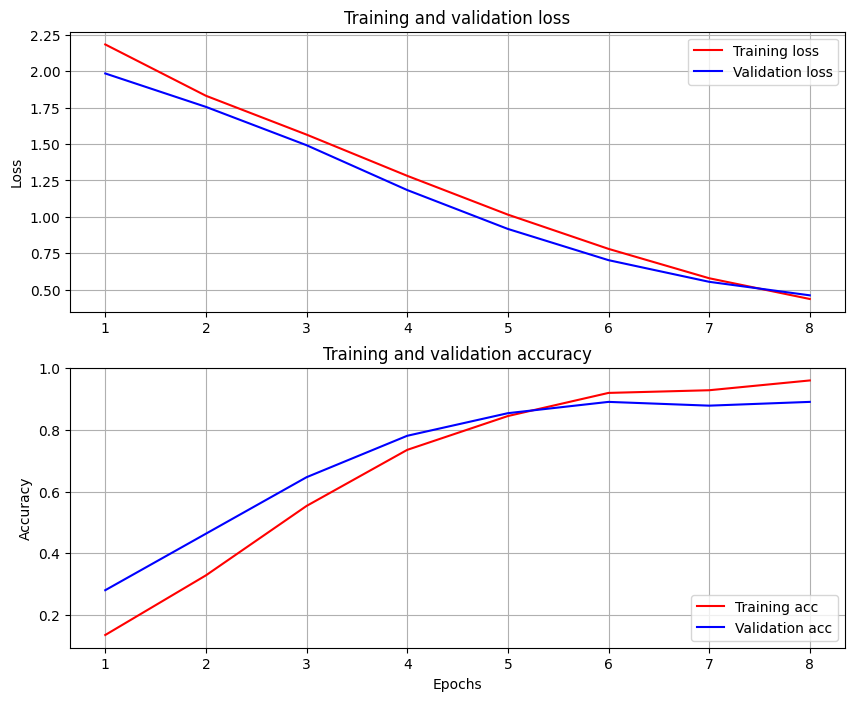

In [24]:
history_dict = history.history

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

Classifying arbitrary instructions:

In [25]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : estimated intent: {results[i]}'
        for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples = [
    'Hey can I please see the documentation',
    'Could use some help with a cron job',
    'How do I deprovision you on the weekends',
    'I have a big issue with that response.',
    'How can I scale your microservices to be more cost-effective?'
]

results = tf.nn.softmax(classifier_model(tf.constant(examples)))
intents = binarizer.inverse_transform(results.numpy())
print_my_examples(examples, intents)

input: Hey can I please see the documentation : estimated intent: documentation
input: Could use some help with a cron job : estimated intent: destroy cron
input: How do I deprovision you on the weekends : estimated intent: destroy cron
input: I have a big issue with that response. : estimated intent: report issue
input: How can I scale your microservices to be more cost-effective? : estimated intent: self scale



#### __Save the model__

In [26]:
classifier_model.save('service/model')

2023-01-17 23:02:42.986410: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We have taken a "DIY" and notebook-centric approach to data preparation, model definition, and training.  Continuing this approach would involve engineering "taking over" at this point, for versioning and productionalization.  However, we can take a more platformized approach with incremental additions of Vertex AI (initially, just for metadata, then for more).

## Adding the custom model to Vertex AI

In [27]:
from google.cloud import aiplatform
from google.cloud import storage

# Vertex AI initialization
aiplatform.init(
    project=GCP_PROJECT,
    location=GCP_REGION,
    experiment=EXPERIMENT_NAME,
)

#### __Create an experiment run for the custom model__

In [28]:
# Start an experiment run (used to compare against other models like BQML and AutoML)
aiplatform.start_run(f"run-custom-{VERTEX_MODEL_ROUND}")

Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-custom-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-custom-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


In [29]:
# Add experiment run parameters
metaparams = {}
metaparams["epochs"] = EPOCHS
metaparams["learning rate"] = 1e-5
metaparams["base model"] = BERT_MODEL_NAME
aiplatform.log_params(metaparams)

# Add experiment run metrics
metrics = {}
metrics["cross-entropy loss"] = history_dict["val_loss"][-1]
metrics["categorical accuracy"] = history_dict["val_categorical_accuracy"][-1]
aiplatform.log_metrics(metrics)

In [30]:
from sklearn.metrics import confusion_matrix

# Use test dataset to compile a confusion matrix
test_copy = test_df.copy()
test_labels = test_copy.pop("intent")
test_features = test_copy.values
test_results = tf.nn.softmax(classifier_model(tf.constant(test_features)))
test_results = binarizer.inverse_transform(test_results.numpy())

labels = list(set(test_labels))
y_true = list(test_labels)
y_pred = list(test_results)

classification_metrics = {
    "matrix": confusion_matrix(y_true, y_pred, labels=labels).tolist(),
    "labels": labels,
}

# Add the confusion matrix to the experiment run
aiplatform.log_classification_metrics(
    labels=classification_metrics["labels"],
    matrix=classification_metrics["matrix"],
    display_name="intents confusion matrix",
)

In [32]:
# Tie the dataset to the model training and experiment run
storage_client = storage.Client()
bucket = storage_client.bucket(GCP_BUCKET)
blob = bucket.blob(f"custom-{VERTEX_MODEL_ROUND}/{DATA_FILE}")
blob.upload_from_filename(DATA_FILE)  # raw data

training_data_artifact = aiplatform.Artifact.create(
    schema_title='system.Dataset',
    uri=f'gs://{GCP_BUCKET}/custom-{VERTEX_MODEL_ROUND}/{DATA_FILE}',
    display_name='labeled intents data'
)

with aiplatform.start_execution(
    schema_title="system.ContainerExecution", 
    display_name='training'
) as execution:
        execution.assign_input_artifacts([training_data_artifact])

        # Upload the model to GCS
        storage_client = storage.Client()
        bucket = storage_client.bucket(GCP_BUCKET)
        for model_file in [
            "saved_model.pb",
            "keras_metadata.pb",
            "assets/vocab.txt",
            "variables/variables.index",
            "variables/variables.data-00000-of-00001"
        ]:
            blob = bucket.blob(f"custom-{VERTEX_MODEL_ROUND}/{model_file}")
            blob.upload_from_filename("service/model/" + model_file)

        # Create a model in the registry
        model = aiplatform.Model.upload(
            display_name=f"{VERTEX_MODEL_NAME_PREFIX}_custom",
            artifact_uri=f"gs://{GCP_BUCKET}/custom-{VERTEX_MODEL_ROUND}",
            description=VERTEX_MODEL_DESCRIPTION,
            serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest"
        )

        model.wait()

        execution.assign_output_artifacts([model])

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/12345678910/locations/us-central1/models/1240990186968449024/operations/8960009109030043648


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/12345678910/locations/us-central1/models/1240990186968449024/operations/8960009109030043648


Model created. Resource name: projects/12345678910/locations/us-central1/models/1240990186968449024@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/12345678910/locations/us-central1/models/1240990186968449024@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/12345678910/locations/us-central1/models/1240990186968449024@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/12345678910/locations/us-central1/models/1240990186968449024@1')


In [33]:
aiplatform.end_run()

## Create an experiment run using BQML

Typically, you'd just run a few lines of SQL code in the BigQuery SQL Workspace, but using the Python SDK here for consistency sake

In [34]:
aiplatform.start_run(f"run-bqml-{VERTEX_MODEL_ROUND}")

Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-bqml-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-bqml-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


In [35]:
# Upload training data to GCS
storage_client = storage.Client()
bucket = storage_client.bucket(GCP_BUCKET)
blob = bucket.blob(f"bqml-{VERTEX_MODEL_ROUND}/{DATA_FILE}")
blob.upload_from_filename(DATA_FILE)  # raw data

In [36]:
from google.cloud import bigquery

client = bigquery.Client()

# Create the BigQuery dataset
dataset_id = f"{GCP_PROJECT}.{BQ_DATASET}"
table_id = f"{GCP_PROJECT}.{BQ_DATASET}.raw_data"
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"
try:
    dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except exceptions.Conflict:
    print("Dataset already exists - choose a new name if the dataset is not under your control")
    pass

# Import data to the BigQuery dataset
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("text", "STRING"),
        bigquery.SchemaField("intent", "STRING"),
    ],
    skip_leading_rows=1,
    # The source format defaults to CSV, so the line below is optional.
    source_format=bigquery.SourceFormat.CSV,
)
uri = f"gs://{GCP_BUCKET}/bqml-{VERTEX_MODEL_ROUND}/{DATA_FILE}"
load_job = client.load_table_from_uri(
    uri, table_id, job_config=job_config
)  # Make an API request.
load_job.result()  # Waits for the job to complete.

# Confirm the loaded data
destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

Dataset already exists - choose a new name if the dataset is not under your control
Loaded 511 rows.


In [37]:
# Create the BQML model
MODEL_QUERY = f"""
CREATE OR REPLACE MODEL
  `{BQ_DATASET}.{VERTEX_MODEL_NAME_PREFIX}_bqml`
OPTIONS
  (
    model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    data_split_method='RANDOM',
    data_split_eval_fraction = .10,
    input_label_cols=['intent'],
    model_registry='vertex_ai'
  ) AS
SELECT 
  ML.NGRAMS(intents.words_array, [1,2]) as ngrams, 
  intents.intent
FROM  (
  SELECT 
    REGEXP_EXTRACT_ALL(LOWER(raw.text), '[a-z]+') as words_array,
    raw.intent
  FROM `{BQ_DATASET}.raw_data` raw
) intents
"""
job = client.query(MODEL_QUERY)
job.result()

In [38]:
# Evaluate the BQML model
EVALUATE_QUERY = f"""
SELECT accuracy, log_loss FROM ML.EVALUATE(MODEL `{BQ_DATASET}.{VERTEX_MODEL_NAME_PREFIX}_bqml`)
"""
job = client.query(EVALUATE_QUERY)
rows = job.result()
results = next(rows)

# Experiment run parameters
metaparams = {}
metaparams["epochs"] = "N/A"
metaparams["learning rate"] = "N/A"
metaparams["base model"] = "N/A"
aiplatform.log_params(metaparams)

# Experiment run metrics
metrics = {}
metrics["cross-entropy loss"] = results.log_loss
metrics["categorical accuracy"] = results.accuracy
aiplatform.log_metrics(metrics)

In [40]:
# Add the model to the experiment run
with aiplatform.start_execution(
    schema_title="system.ContainerExecution", 
    display_name='training'
) as execution:
    execution.assign_output_artifacts([aiplatform.Model(model_name=f"{VERTEX_MODEL_NAME_PREFIX}_bqml")])

In [41]:
aiplatform.end_run()

## Create an experiment run using AutoML

Part of the value of AutoML is that it's no-code.  The Python below is only for consistency sake (consider other mechanisms like the Cloud Console GUI for easier setup).

In [42]:
aiplatform.start_run(f"run-automl-{VERTEX_MODEL_ROUND}")

Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-automl-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/12345678910/locations/us-central1/metadataStores/default/contexts/isidro-intents-compare-custom-automl-bqml-run-automl-r1 to Experiment: isidro-intents-compare-custom-automl-bqml


In [43]:
# Remove the headers from the CSV file
headerless_data = ""
with open(DATA_FILE, 'r') as data_file:
    next(data_file)  # Skip the header row
    for line in data_file:
        headerless_data += line

# Upload data and schema to GCS
storage_client = storage.Client()
bucket = storage_client.bucket(GCP_BUCKET)
bucket.blob(f"automl-{VERTEX_MODEL_ROUND}/headerless-{DATA_FILE}").upload_from_string(headerless_data, 'text/csv')

In [44]:
# Create a Managed Dataset
text_dataset = aiplatform.TextDataset.create(
    display_name=f"{VERTEX_MODEL_NAME_PREFIX}_automl",
    gcs_source=f"gs://{GCP_BUCKET}/automl-{VERTEX_MODEL_ROUND}/headerless-{DATA_FILE}",
    import_schema_uri=aiplatform.schema.dataset.ioformat.text.single_label_classification
)

# Train an AutoML model off the Managed Dataset
job = aiplatform.AutoMLTextTrainingJob(
    display_name=f"{VERTEX_MODEL_NAME_PREFIX}_automl",
    prediction_type="classification",
    multi_label=False,
)
model = job.run(
    dataset=text_dataset,
    model_display_name=f"{VERTEX_MODEL_NAME_PREFIX}_automl",
    training_fraction_split=0.68,
    validation_fraction_split=0.16,
    test_fraction_split=0.16,
)

# Add the model to the experiment run
with aiplatform.start_execution(
    schema_title="system.ContainerExecution", 
    display_name='training'
) as execution:
    execution.assign_output_artifacts([model])

Creating TextDataset


INFO:google.cloud.aiplatform.datasets.dataset:Creating TextDataset


Create TextDataset backing LRO: projects/12345678910/locations/us-central1/datasets/7477763187341787136/operations/8187641772936003584


INFO:google.cloud.aiplatform.datasets.dataset:Create TextDataset backing LRO: projects/12345678910/locations/us-central1/datasets/7477763187341787136/operations/8187641772936003584


TextDataset created. Resource name: projects/12345678910/locations/us-central1/datasets/7477763187341787136


INFO:google.cloud.aiplatform.datasets.dataset:TextDataset created. Resource name: projects/12345678910/locations/us-central1/datasets/7477763187341787136


To use this TextDataset in another session:


INFO:google.cloud.aiplatform.datasets.dataset:To use this TextDataset in another session:


ds = aiplatform.TextDataset('projects/12345678910/locations/us-central1/datasets/7477763187341787136')


INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TextDataset('projects/12345678910/locations/us-central1/datasets/7477763187341787136')


Importing TextDataset data: projects/12345678910/locations/us-central1/datasets/7477763187341787136


INFO:google.cloud.aiplatform.datasets.dataset:Importing TextDataset data: projects/12345678910/locations/us-central1/datasets/7477763187341787136


Import TextDataset data backing LRO: projects/12345678910/locations/us-central1/datasets/7477763187341787136/operations/2267660062757486592


INFO:google.cloud.aiplatform.datasets.dataset:Import TextDataset data backing LRO: projects/12345678910/locations/us-central1/datasets/7477763187341787136/operations/2267660062757486592


TextDataset data imported. Resource name: projects/12345678910/locations/us-central1/datasets/7477763187341787136


INFO:google.cloud.aiplatform.datasets.dataset:TextDataset data imported. Resource name: projects/12345678910/locations/us-central1/datasets/7477763187341787136


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7351014922865606656?project=12345678910


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7351014922865606656?project=12345678910


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLTextTrainingJob run completed. Resource name: projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656


INFO:google.cloud.aiplatform.training_jobs:AutoMLTextTrainingJob run completed. Resource name: projects/12345678910/locations/us-central1/trainingPipelines/7351014922865606656


Model available at projects/12345678910/locations/us-central1/models/684373420523126784


INFO:google.cloud.aiplatform.training_jobs:Model available at projects/12345678910/locations/us-central1/models/684373420523126784


In [46]:
# Add experiment run parameters
metaparams = {}
metaparams["epochs"] = "N/A"
metaparams["learning rate"] = "N/A"
metaparams["base model"] = "N/A"
aiplatform.log_params(metaparams)

In [47]:
# Add experiment run metrics
model_evaluations = model.list_model_evaluations()
for model_evaluation in model_evaluations:
    log_loss = model_evaluation.metrics["logLoss"]
metrics = {}
metrics["cross-entropy loss"] = log_loss
aiplatform.log_metrics(metrics)

In [48]:
aiplatform.end_run()

## Experiment analysis (across custom model, BQML, and AutoML)

In [49]:
experiment_df = aiplatform.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df

,experiment_name,run_name,run_type,state,param.epochs,param.base model,param.learning rate,metric.cross-entropy loss,metric.categorical accuracy
0,isidro-intents-compare-custom-automl-bqml,run-automl-r1,system.ExperimentRun,COMPLETE,N/A,N/A,N/A,0.035308,NaN
1,isidro-intents-compare-custom-automl-bqml,run-bqml-r1,system.ExperimentRun,COMPLETE,N/A,N/A,N/A,0.036435,0.981132
2,isidro-intents-compare-custom-automl-bqml,run-custom-r1,system.ExperimentRun,COMPLETE,8.0,small_bert/bert_en_uncased_L-8_H-512_A-8,0.00001,0.461158,0.890244


In [50]:
experiment_run = aiplatform.ExperimentRun(
        run_name=f"run-custom-{VERTEX_MODEL_ROUND}",
        experiment=EXPERIMENT_NAME,
)

print(experiment_run.get_artifacts())
print(experiment_run.get_metrics())
print(experiment_run.get_params())
print(experiment_run.get_time_series_data_frame())
print(experiment_run.get_classification_metrics())

resource name: projects/12345678910/locations/us-central1/metadataStores/default/artifacts/09422771-6759-45e5-aeb2-c7155b2b0144
uri: https://us-central1-aiplatform.googleapis.com/v1/projects/12345678910/locations/us-central1/models/1240990186968449024@1
schema_title:google.VertexModel, <google.cloud.aiplatform.metadata.artifact.Artifact object at 0x7fe2a4690350> 
resource name: projects/12345678910/locations/us-central1/metadataStores/default/artifacts/7b92f9ec-ef9b-4e17-ad28-b1b4a026f200
uri: gs://isidro_intent_classification/custom-r1/quality.csv
schema_title:system.Dataset, <google.cloud.aiplatform.metadata.artifact.Artifact object at 0x7fe2a4690ed0> 
resource name: projects/12345678910/locations/us-central1/metadataStores/default/artifacts/74feb581-a4a4-4fa5-8575-80cd25142268
uri: gs://isidro_intent_classification/custom-r1/quality.csv
schema_title:system.Dataset, <google.cloud.aiplatform.metadata.artifact.Artifact object at 0x7fe2a47de510> 
resource name: projects/12345678910/loca